# Kaggle Spooky Author Identification Entry

**Name**: George-Bogdan Ivanov
**Contact**: human@nlpforhackers.io
**Website**: http://nlpforhackers.io



In [106]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import RegexpParser

import matplotlib.pyplot as plt

## Load Data

In [28]:
df = pd.read_csv('data/train.csv')
text, author = df['text'], df['author']
X_train, X_test, y_train, y_test = train_test_split(text, author, test_size=0.2, shuffle=True)


## First simple attempt

In [41]:
p1 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression()),
])

p1.fit(X_train, y_train)
print(p1.score(X_test, y_test))

0.82379979571


In [40]:
p2 = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', LogisticRegression()),
])

p2.fit(X_train, y_train)
print(p2.score(X_test, y_test))

0.828651685393


In [43]:
p5 = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', LogisticRegression()),
])

p5.fit(X_train, y_train)
print(p5.score(X_test, y_test))

0.79468845761


In [39]:
p3 = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression()),
])

p3.fit(X_train, y_train)
print(p3.score(X_test, y_test))

0.811542390194


## Swithing to a different model

In [48]:
p4 = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', GradientBoostingClassifier(verbose=True,
        n_estimators=200, max_leaf_nodes=4, max_depth=2,
        learning_rate=0.1, subsample=1.0)),
])

p4.fit(X_train, y_train)
print(p4.score(X_test, y_test))

      Iter       Train Loss   Remaining Time 
         1       16878.3227            2.67m
         2       16688.7824            2.72m
         3       16529.1464            2.69m
         4       16386.8890            2.70m
         5       16262.2248            2.70m
         6       16149.5414            2.69m
         7       16038.6264            2.67m
         8       15943.5917            2.64m
         9       15854.7682            2.63m
        10       15773.1674            2.64m
        20       15137.7731            2.54m
        30       14683.9859            2.38m
        40       14317.6810            2.23m
        50       14010.4994            2.10m
        60       13742.1429            1.96m
        70       13507.1217            1.82m
        80       13289.1094            1.68m
        90       13096.4793            1.54m
       100       12920.3440            1.42m
       200       11622.3340            0.00s
0.687436159346


In [92]:
p6 = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=64, verbose=True)),
])

p6.fit(X_train, y_train)
print(p6.score(X_test, y_test))

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  1.3min finished


0.660878447395


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished


## Try a different tokenizer

In [54]:
p5 = Pipeline([
    ('vectorizer', CountVectorizer(
        ngram_range=(1, 2), tokenizer=word_tokenize)),
    ('classifier', LogisticRegression()),
])

p5.fit(X_train, y_train)
print(p5.score(X_test, y_test))

0.834780388151


## Feature Engineering

### Sentence Length

In [85]:
from collections import defaultdict
from nltk import sent_tokenize, word_tokenize

classes = set(train_Y)
sentence_word_count = defaultdict(lambda: 0)
sentence_count = defaultdict(lambda: 0)
sentence_dist = {a: defaultdict(lambda: 0) for a in classes}

for author in classes:
    author_df = df[df['author'] == author]
    idx = 1
    for _, row in author_df.iterrows():
        if idx % 1000 == 0:
            print("%s/%s texts processed" % (idx, len(author_df)))
        sentences = sent_tokenize(row['text'])
        sentence_count[author] += len(sentences)
        for s in sentences:
            words = word_tokenize(s)
            sentence_word_count[author] += len(words)
            sentence_dist[author][len(words)] += 1
        idx += 1
    print("Finished for author %s\n" % author)

mean_sentence_word_count = {a: sentence_word_count[a] / sentence_count[a] for a in classes}
print(mean_sentence_word_count)

1000/5635 texts processed
2000/5635 texts processed
3000/5635 texts processed
4000/5635 texts processed
5000/5635 texts processed
Finished for author HPL

1000/7900 texts processed
2000/7900 texts processed
3000/7900 texts processed
4000/7900 texts processed
5000/7900 texts processed
6000/7900 texts processed
7000/7900 texts processed
Finished for author EAP

1000/6044 texts processed
2000/6044 texts processed
3000/6044 texts processed
4000/6044 texts processed
5000/6044 texts processed
6000/6044 texts processed
Finished for author MWS

{'HPL': 29.608407079646017, 'EAP': 28.29441871801121, 'MWS': 30.81331592689295}


AUTHOR:  HPL


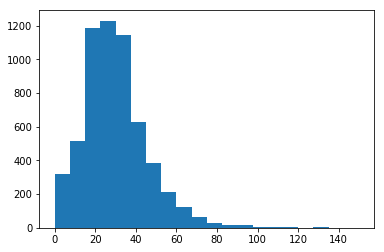

AUTHOR:  EAP


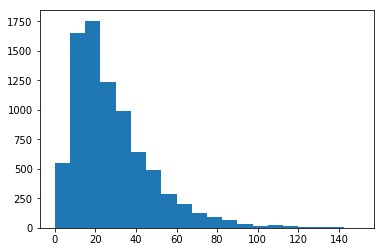

AUTHOR:  MWS


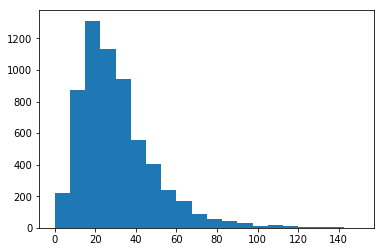

In [83]:
def iter_df_sent_word_count(df):
    for _, row in df.iterrows():
        sentences = sent_tokenize(row['text'])
        for s in sentences:
            words = word_tokenize(s)
            yield len(words)

for author in classes:
    print("AUTHOR: ", author)
    author_df = df[df['author'] == author]
    plt.hist(list(iter_df_sent_word_count(author_df)), bins=20, range=(0, 150))
    plt.show()

## Adjectives/Adverbs per sentence

In [87]:
from collections import defaultdict
from nltk import sent_tokenize, word_tokenize, pos_tag

classes = set(train_Y)
sentence_count = defaultdict(lambda: 0)
sentence_adjadv_percent = defaultdict(lambda: 0)


for author in classes:
    author_df = df[df['author'] == author]
    idx = 1
    for _, row in author_df.iterrows():
        if idx % 1000 == 0:
            print("%s/%s texts processed" % (idx, len(author_df)))
        sentences = sent_tokenize(row['text'])
        sentence_count[author] += len(sentences)
        for s in sentences:
            words = word_tokenize(s)
            adjadv = len([w for w, t in pos_tag(words) if t.startswith("RB") or t.startswith("JJ")])
            sentence_adjadv_percent[author] += adjadv / len(words)
        idx += 1
    print("Finished for author %s\n" % author)

mean_sentence_word_count = {sentence_adjadv_percent[a] / sentence_count[a] for a in classes}
print(mean_sentence_word_count)

1000/5635 texts processed
2000/5635 texts processed
3000/5635 texts processed
4000/5635 texts processed
5000/5635 texts processed
Finished for author HPL

1000/7900 texts processed
2000/7900 texts processed
3000/7900 texts processed
4000/7900 texts processed
5000/7900 texts processed
6000/7900 texts processed
7000/7900 texts processed
Finished for author EAP

1000/6044 texts processed
2000/6044 texts processed
3000/6044 texts processed
4000/6044 texts processed
5000/6044 texts processed
6000/6044 texts processed
Finished for author MWS

{0.12968107643798327, 0.10498349821348991, 0.1219764694386742}


AUTHOR: HPL


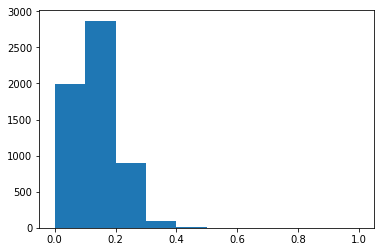

AUTHOR: EAP


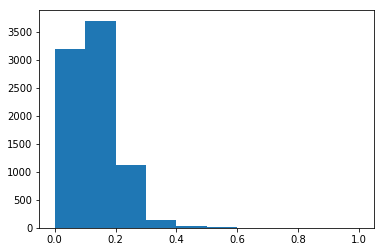

AUTHOR: MWS


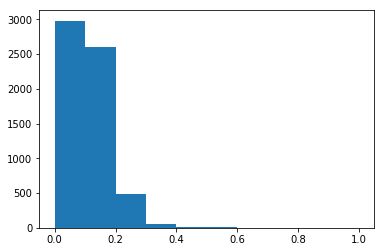

In [93]:
def iter_df_sent_adjadv_count(df):
    for _, row in df.iterrows():
        sentences = sent_tokenize(row['text'])
        for s in sentences:
            words = word_tokenize(s)
            adjadv = len([w for w, t in pos_tag(words) if t.startswith("RB") or t.startswith("JJ")])
            yield adjadv / len(words)
            
for author in classes:
    print("AUTHOR:", author)
    author_df = df[df['author'] == author]
    plt.hist(list(iter_df_sent_adjadv_count(author_df)), bins=10, range=(0, 1))
    plt.show()

## Phrasal Verbs

In [129]:
import re
import string

phrasal_verbs_grammar = """
PV:
    {<act%%> <up>}
    {<add%%> <.*>? <up>}
    {<ask%%> <around>}
    {<ask%%> <.*>? <out|over>}
    {<back%%> <.*>? <up>}
    {<back%%> <down|out|up>}
    {<bawl%%> <.*>? <out>}
    {<bear|bore|born> <down> <on>}
    {<bear|bore|born> <on|up|with>}
    {<blow|blew|blown> <.*>? <up>}
    {<blow|blew|blown> <in|over|up>}
    {<break|broke|broken> <.*>? <down|in|off|up>}
    {<break|broke|broken> <into|out>}
    {<bring|brought> <.*>? <about|along|around|away|back|down|in|off|on|out|over|to|up|forward|>}
    {<brush%%> <.*>? <off>}
    {<burn%%> <.*>? <down|up>}
    {<buy|bought> <.*>? <out|up>}
    {<buy|bought> <into>}
    {<call%%> <.*>? <off|up>}
    {<call%%> <for|on|upon>}
    {<calm%%> <.*>? <down>}
    {<care|cares|caring|cared> <for>}
    {<carry|carried|carries|carrying> <.*>? <out|over>}
    {<carry|carried|carries|carrying> <on>}
    {<catch|caught%%> <on|up>}
    {<check%%> <.*>? <off|out|over|through>}
    {<check%%> <back|by|in|into|on|out|with>}
    {<check%%> <up> <on>}
    {<cheer%%> <.*>? <up>}
    {<chip%%> <in>}
    {<chop%%> <.*>? <down|up>}
    {<clear%%> <out>}
    {<close|closing|closes|closed> <.*>? <down|up>}
    {<close|closing|closes|closed> <in> <on>}
    {<come|came|comes|coming> <about|across|along|away|by|down|in|into|off|on|out|over|round|through|up|with>}
    {<cope|coped|coping|copes> <with>}
    {<count%%> <.*>? <in|out|up>}
    {<count%%> <on>}
    {<crack%%> <down> <on>}
    {<crack%%> <up>}
    {<cross%%> <.*>? <out>}
    {<cut|cuts|cutten|cutting> <.*>? <off|out|up>}
    {<cut|cuts|cutten|cutting> <down|in>}
    {<deal|dealt|deals|dealing> <with>}
    {<die|dies|dying|died> <away|down|off|out>}
    {<disagree%%> <with>}
    {<do|done|did|doing|does> <.*>? <over>}
    {<do|done|did|doing|does> <away> <with>}
    {<do|done|did|doing|does> <without>}
    {<draw|drew|drawn|draws|drawing%%> <.*>? <up>}
    {<dress%%> <.*>? <down|up>}
    {<drive|drove|driven|driving|drives> <.*>? <back>}
    {<drop%%> <in|out|over>}
    {<drop%%> <.*>? <off>}
    {<eat|eats|ate|eaten|eats> <.*>? <up>}
    {<eat%%> <away|in|out|up>}
    {<face|faces|facing|faced> <up> <to>}
    {<fall|fell|falling|falls|fallen> <back> <on>}
    {<fall|fell|falling|falls|fallen> <apart|behind|off|through>}
    {<fall|fell|falling|falls|fallen> <out> <with>}
    {<feel|felt|feeling|feels> <.*>? <up>}
    {<fight|fought|fights|fighting> <back|on>}
    {<figure%%> <.*>? <up|out>}
    {<fill%%> <.*>? <out|up|in>}
    {<find|found|finding|finds|finding> <.*>? <out>}
    {<fix%%> <.*>? <up>}
    {<follow%%> <through>}
    {<follow%%> <up> <on>}
    {<get|got|gotten|gets|getting> <.*>? <across|back|off|on|out|up>}
    {<get|got|gotten|gets|getting> <ahead|along|around|away|by|in|into|over|through>}
    {<get|got|gotten|gets|getting> <back|down> <to>}
    {<get|got|gotten|gets|getting> <in|into|over|through>}
    {<give|gave|given|giving|gives> <off>}
    {<give|gave|given|giving|gives> <.*>? <back|out|up|away>}
    {<give|gave|given|giving|gives> <in>}
    {<go|went|gone|going|goes> <after|ahead|along|away|back|by|down|for|in|into|off|on|out|over|round|through|up|with|without>}
    {<grow|grew|grown|grows|growing> <under|up>}
    {<hand%%> <.*>? <back|down|in|out|over|up>}
    {<hang|hung|hanged|hanging|hangs> <around|out>}
    {<have|had|having|has> <.*>? <on|over>}
    {<hear%%> <from|of>}
    {<hit|hitting|hits> <on>}
    {<hold|held|holds|holding> <.*>? <back|off|up>}
    {<hold|held|holds|holding> <on|out>}
    {<hook%%> <.*>? <up>}
    {<iron%%> <.*>? <out>}
    {<jack%%> <up>}
    {<join%%> <in>}
    {<joke|jokes|joking|jokes|joked> <around>}
    {<jump%%> <in|to>}
    {<keep|kept|keeping|keeps> <.*>? <around|away|back|down|in|off|out|over|up>}    
    {<keep|kept|keeping|keeps> <at|on|to>}
    {<kick%%> <back|in>}
    {<knock%%> <over|out>}
    {<lay|laid|lays|laying> <.*>? <down|off|out>}
    {<lay|laid|lays|laying> <in> <on>}
    {<lay|laid|lays|laying> <into>}
    {<leave|left|leaves|leaving> <.*>? <out>}
    {<let|lets|letting> <.*>? <down|out>}
    {<let|lets|letting> <up>}
    {<lie%%> <down|with>}
    {<light%%> <.*>? <up>}
    {<live|lives|living|lived> <.*>? <down>}
    {<live|lives|living|lived> <on|with>}
    {<live|lives|living|lived> <up> <to>}
    {<look%%> <.*>? <over|up>}
    {<look%%> <after|around|back|down|for|forward|into|on|out|round|up>}
    {<look%%> <up> <to>}
    {<make|making|made|makes> <.*>? <out|over|up>}
    {<mix%%> <.*>? <up>}
    {<move|moves|moving|moved> <.*>? <back|in|out|up>}
    {<move|moves|moving|moved> <on>}
    {<name|names|naming|named> <.*>? <after>}
    {<nod|nodded|nods|nodding> <off>}
    {<nose|noses|nosed|nosing> <around>}
    {<occur%%> <to>}
    {<open%%> <up>}
    {<pan%%> <out>}
    {<pass%%> <.*>? <off|on|up|out>}
    {<pass%%> <away>}
    {<pay|paid|paying|pays> <.*>? <back|off>}
    {<pick%%> <.*>? <out|up>}
    {<pick%%> <on>}
    {<play%%> <.*>? <down|up>}
    {<point%%> <.*>? <out>}
    {<pull%%> <down|in|out|through>}
    {<put|puts|putting> <.*>? <across|away|back|down|in|off|on|out|up|forward|together>}
    {<quiet%%> <.*>? <down>}
    {<ring|rang|rung|ringing|rings> <.*>? <up>}
    {<rule|rulling|rules|ruled> <.*>? <out>}
    {<run|running|runs|ran> <.*>? <down|off>}
    {<run|running|runs|ran> <across|against|away|for|into|through>}
    {<run|running|runs|ran> <out> <of>}
    {<save%%> <.*>? <up>}
    {<screw%%> <.*>? <up>}
    {<see|saw|seen|seeing|sees> <.*>? <off|through>}
    {<see|saw|seen|seeing|sees> <about|to>}
    {<sell|sells|sold|selling> <.*>? <out>}
    {<set|sets|setting> <.*>? <down|off|out|up>}
    {<set|sets|setting> <about>}
    {<settle%%> <on|up>}
    {<show|shew|shown|shows"showing> <.*>? <off|up>}
    {<shut|shutting|shuts> <.*>? <off|up|down>}
    {<sign%%> <off>}
    {<sit|sat|sits|sitting> <back|down|up>}
    {<slow%%> <.*>? <down|up>}
    {<spell%%> <.*>? <out>}
    {<spend|spending|spends|spent> <away>}
    {<stand|stood|standing|stands> <.*>? <up>}
    {<stand|stood|standing|stands> <by|for|out>}
    {<stand|stood|standing|stands> <up> <to>}
    {<stay%%> <over>}
    {<stick|sticks|stuck|sticking> <it> <to>}
    {<stick|sticks|stuck|sticking> <to|with>}
    {<stick|sticks|stuck|sticking> <up> <for>}
    {<strip%%> <down|off>}
    {<take|took|taken|takes|taking> <.*>? <away|back|down|for|in|off|on|out|over|up>}
    {<take|took|taken|takes|taking> <after>}
    {<take|took|taken|takes|taking> <.*>? <over>}
    {<take|took|taken|takes|taking> <back>}
    {<tear|tore|torn|tearing|tears> <.*>? <down|down>}
    {<tell|told|telling|tells> <.*>? <off>}
    {<tell|told|telling|tells> <on>}
    {<think|thought|thinks|thinking> <.*>? <over|through|up>}
    {<throw|threw|thrown|throws|throwing> <.*>? <up|away|out>}
    {<tie|ties|tying|tied> <.*>? <up>}
    {<tire|tired|tiring> <.*>? <out>}
    {<touch%%> <.*>? <up>}
    {<touch%%> <on>}
    {<try|tries|tried|trying> <.*>? <on|out>}
    {<turn%%> <.*>? <around|away|back|down|off|out|over|up|in|on>}    
    {<turn%%> <into|round>}
    {<use%%> <.*>? <up>}
    {<veer%%> <away> <from>}
    {<wait%%> <on|up>}
    {<wake|woke|waken|waking|wakes> <.*>? <up>}
    {<wash%%> <.*>? <up>}
    {<watch%%> <out>}
    {<wear|wore|worn|wears|wearing> <.*>? <out|down>}
    {<wear|wore|worn|wears|wearing> <off>}
    {<wind%%> <.*>? <up>}
    {<wipe%%> <.*>? <out>}
    {<work%%> <out>}
    {<write%%> <.*>? <down|out|up>}
    {<yak%%> <on> <about>?}    
    {<yammer%%> <on> <about>?}
    {<zero%%> <in> <on>}
    {<zip%%> <around>}
    {<zone%%> <out>}
    {<zonk%%> <out>}
    {<zoom%%> <in>}
"""

phrasal_verbs_grammar = phrasal_verbs_grammar.replace("%%", "(ing|d|ed|ied|s|es|ies)?")
# print(phrasal_verbs_grammar)

chunker = RegexpParser(phrasal_verbs_grammar)
print(chunker.parse([('I', 'I'), ('was', 'was'), ('acting', 'acting'), ('up', 'up'), ('for', 'for'), ('nothing', 'nothing')]))
print(chunker.parse([('I', 'I'), ('was', 'was'), ('asking', 'asking'), ('over', 'over'), ('for', 'for'), ('nothing', 'nothing')]))
print(chunker.parse([('I', 'I'), ('wore', 'wore'), ('me', 'me'), ('down', 'down'), ('for', 'for'), ('nothing', 'nothing')]))

(S I/I was/was (PV acting/acting up/up) for/for nothing/nothing)
(S I/I was/was (PV asking/asking over/over) for/for nothing/nothing)
(S I/I (PV wore/wore me/me down/down) for/for nothing/nothing)


In [103]:
p7 = Pipeline([
    ('vectorizer', CountVectorizer(
        ngram_range=(1, 2), tokenizer=lambda text: extract_phrasals(text)[2])),
    ('classifier', LogisticRegression()),
])

p7.fit(X_train, y_train)
print(p7.score(X_test, y_test))

0.410112359551


In [125]:
phrasalverbs = [
    "act up ",
    "add * up",
    "ask around",
    "ask * out",
    "ask * over",
    "back * up",
    "back down ",
    "back out ",
    "back up ",
    "bawl * out",
    "bear down on",
    "bear on",
    "bear up ",
    "bear with",
    "blow * up",
    "blow in ",
    "blow over ",
    "blow up ",
    "break * down",
    "break * in",
    "break * off",
    "break * up",
    "break into",
    "break out",
    "bring * about",
    "bring * along",
    "bring * around ",
    "bring * away ",
    "bring * back",
    "bring * down",
    "bring * in",
    "bring * off",
    "bring * on",
    "bring * out",
    "bring * out",
    "bring * over",
    "bring * to ",
    "bring * up",
    "bring * forward",
    "brush * off",
    "burn * down",
    "burn * up",
    "buy * out ",
    "buy * up",
    "buy into",
    "call * off",
    "call * up ",
    "call for",
    "call on",
    "call upon",
    "calm * down",
    "care for",
    "carry * out",
    "carry * over",
    "carry on",
    "carry * out",
    "catch on ",
    "catch up ",
    "check * off",
    "check * out",
    "check * over",
    "check * through",
    "check back ",
    "check by",
    "check in ",
    "check into",
    "check on",
    "check out ",
    "check up on",
    "check with",
    "cheer * up ",
    "chip in",
    "chop * down ",
    "chop * up",
    "clear out ",
    "close * down",
    "close * up",
    "close in on",
    "come about",
    "come across ",
    "come along",
    "come away ",
    "come by ",
    "come down",
    "come in",
    "come into",
    "come off",
    "come on",
    "come out",
    "come over",
    "come round",
    "come through",
    "come up",
    "come with",
    "cope with",
    "count * in",
    "count * out",
    "count * up",
    "count on",
    "crack down on",
    "crack up ",
    "cross * out",
    "cut * off ",
    "cut * out ",
    "cut * up",
    "cut down ",
    "cut in ",
    "deal with",
    "die away ",
    "die down ",
    "die off",
    "die out",
    "disagree with",
    "do * over",
    "do away with",
    "do without",
    "draw * up",
    "dress * down",
    "dress * up",
    "drive * back",
    "drop in ",
    "drop * off",
    "drop out ",
    "drop over",
    "eat * up",
    "eat away ",
    "eat in",
    "eat out ",
    "end up",
    "face up to",
    "fall apart",
    "fall back on",
    "fall behind ",
    "fall off ",
    "fall out with",
    "fall through ",
    "feel * up",
    "fight back",
    "figure * up",
    "figure on  ",
    "figure * out",
    "fill * out  ",
    "fill * up  ",
    "fill * in ",
    "find * out",
    "fix * up  ",
    "follow through",
    "follow up on",
    "get * across",
    "get * back",
    "get * off",
    "get * on",
    "get * out",
    "get * up",
    "get ahead",
    "get along",
    "get around",
    "get away",
    "get back to",
    "get by",
    "get down to",
    "get in",
    "get into",
    "get over",
    "get through",
    "give  off",
    "give * back",
    "give * out",
    "give * out",
    "give * up",
    "give * away",
    "give in",
    "go after",
    "go ahead",
    "go along",
    "go away ",
    "go back",
    "go by",
    "go down",
    "go for",
    "go in",
    "go into",
    "go off",
    "go on",
    "go out",
    "go over",
    "go round",
    "go through",
    "go up",
    "go with",
    "go without",
    "grow under",
    "grow up",
    "hand * back",
    "hand * down",
    "hand * in",
    "hand * out",
    "hand * over",
    "hand * out",
    "hang * up",
    "hang around",
    "hang out",
    "have * on",
    "have * over",
    "hear from",
    "hear of",
    "hit on",
    "hold * back",
    "hold * off",
    "hold * up",
    "hold on",
    "hold out",
    "hold * up",
    "hook * up",
    "iron * out",
    "jack up",
    "join in",
    "joke around",
    "jump in",
    "jump to",
    "keep * around",
    "keep * away",
    "keep * back",
    "keep * down",
    "keep * in",
    "keep * off",
    "keep * out",
    "keep * over",
    "keep at",
    "keep on",
    "keep to",
    "keep * up",
    "kick back",
    "kick in",
    "knock over",
    "knock out",
    "lay * down",
    "lay * off",
    "lay * out",
    "lay in on",
    "lay into",
    "leave * out",
    "let * down ",
    "let * out",
    "let up",
    "lie down",
    "lie with",
    "light * up",
    "live * down",
    "live on",
    "live up to",
    "live with",
    "look * over",
    "look * up",
    "look after",
    "look around",
    "look back",
    "look down",
    "look for",
    "look forward",
    "look into",
    "look on",
    "look out",
    "look round",
    "look up",
    "look up to",
    "make * out",
    "make * over",
    "make * up",
    "mix * up",
    "move * back",
    "move * in",
    "move * out",
    "move * up",
    "move on",
    "name * after",
    "nod off",
    "nose around",
    "occur to",
    "open up",
    "pan out",
    "pass * off",
    "pass * on",
    "pass * up",
    "pass away",
    "pass * out",
    "pay * back",
    "pay * off",
    "pick * out",
    "pick * up",
    "pick on",
    "play * down",
    "play * up",
    "point * out",
    "pull down",
    "pull in",
    "pull out",
    "pull through",
    "put * across",
    "put * away",
    "put * back",
    "put * down",
    "put * in",
    "put * off",
    "put * on",
    "put * out",
    "put * up",
    "put * forward",
    "put * together",
    "quiet * down",
    "ring * up ",
    "rule * out",
    "run * down",
    "run * off",
    "run across",
    "run against",
    "run away",
    "run for",
    "run into",
    "run out of",
    "run through",
    "save * up",
    "screw * up",
    "see * off",
    "see * through",
    "see about",
    "see to",
    "sell * out",
    "set * down",
    "set * off",
    "set * out",
    "set * up",
    "set about",
    "settle on",
    "settle up",
    "show * off",
    "show * up",
    "shut * off",
    "shut * up",
    "shut * down",
    "shut * up",
    "sign off",
    "sit back",
    "sit down",
    "sit up",
    "slow * down",
    "slow * up",
    "spell * out",
    "spend away",
    "stand * up",
    "stand by",
    "stand for",
    "stand out",
    "stand up to",
    "stay over",
    "stick it to",
    "stick to",
    "stick up for",
    "stick with",
    "strip down",
    "strip off",
    "take * away",
    "take * back",
    "take * down",
    "take * for",
    "take * in",
    "take * off",
    "take * on",
    "take * out",
    "take * over",
    "take * up",
    "take after",
    "talk * over",
    "talk back",
    "tear * down",
    "tear * up",
    "tell * off",
    "tell on",
    "think * over",
    "think * through",
    "think * up",
    "throw * up",
    "throw * away",
    "throw * out",
    "tie * up",
    "tire * out",
    "touch * up",
    "touch on",
    "try * on",
    "try * out",
    "turn * around",
    "turn * away",
    "turn * back",
    "turn * down",
    "turn * off",
    "turn * out",
    "turn * over",
    "turn * up",
    "turn * in",
    "turn into",
    "turn * on",
    "turn round",
    "use * up ",
    "veer away from",
    "wait on",
    "wait up",
    "wake * up",
    "wash * up",
    "watch out",
    "wear * out",
    "wear off",
    "wind * up",
    "wipe * out",
    "work out",
    "write * down",
    "write * out",
    "write * up",
    "yak on",
    "yak on about",
    "yammer on",
    "yammer on about",
    "zero in on",
    "zip around",
    "zone out",
    "zonk out",
    "zoom in",
]

print(max([len(p.split(' ')) for p in phrasalverbs]))


grammar = "PV:\n"
lines = []
for p in phrasalverbs:
    p = p.strip()
    frame = "    {%s}\n"
    expr = ""
    tokens = p.split(' ')
    expr += "<%s%%%%> " % tokens[0]
    for t in tokens[1:]:
        if t == '*':
            expr += "<.*>? "
        else:
            expr += "<%s>" % t

    line = frame % expr
            
    if line not in lines:    
        lines.append(line)
        grammar += line
    
print(grammar)


5
PV:
    {<act%%> <up>}
    {<add%%> <.*>? <up>}
    {<ask%%> <around>}
    {<ask%%> <.*>? <out>}
    {<ask%%> <.*>? <over>}
    {<back%%> <.*>? <up>}
    {<back%%> <down>}
    {<back%%> <out>}
    {<back%%> <up>}
    {<bawl%%> <.*>? <out>}
    {<bear%%> <down><on>}
    {<bear%%> <on>}
    {<bear%%> <up>}
    {<bear%%> <with>}
    {<blow%%> <.*>? <up>}
    {<blow%%> <in>}
    {<blow%%> <over>}
    {<blow%%> <up>}
    {<break%%> <.*>? <down>}
    {<break%%> <.*>? <in>}
    {<break%%> <.*>? <off>}
    {<break%%> <.*>? <up>}
    {<break%%> <into>}
    {<break%%> <out>}
    {<bring%%> <.*>? <about>}
    {<bring%%> <.*>? <along>}
    {<bring%%> <.*>? <around>}
    {<bring%%> <.*>? <away>}
    {<bring%%> <.*>? <back>}
    {<bring%%> <.*>? <down>}
    {<bring%%> <.*>? <in>}
    {<bring%%> <.*>? <off>}
    {<bring%%> <.*>? <on>}
    {<bring%%> <.*>? <out>}
    {<bring%%> <.*>? <over>}
    {<bring%%> <.*>? <to>}
    {<bring%%> <.*>? <up>}
    {<bring%%> <.*>? <forward>}
    {<brush%%> <.*>? <o